In [1]:
# Decision Tree Model with Imputation for Missing Values and Encoding for Categorical Data

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.multioutput import MultiOutputClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
# Load the datasets
X_train_df = pd.read_csv('D:\\Uni_Bamberg\\En_el_extranjero\\UCLM\\ML\\ML\\src\\training_set_features.csv', index_col='respondent_id')
training_set_labels_df = pd.read_csv('D:\\Uni_Bamberg\\En_el_extranjero\\UCLM\\ML\\ML\\src\\training_set_labels.csv', index_col='respondent_id')
X_test_df = pd.read_csv('D:\\Uni_Bamberg\\En_el_extranjero\\UCLM\\ML\\ML\\src\\test_set_features.csv', index_col='respondent_id')



In [3]:
# Check Missing Values
missing_percentages = X_train_df.isnull().mean()
print("Missing percentages in training set:")
print(missing_percentages[missing_percentages > 0])

Missing percentages in training set:
h1n1_concern                   0.003445
h1n1_knowledge                 0.004343
behavioral_antiviral_meds      0.002658
behavioral_avoidance           0.007788
behavioral_face_mask           0.000711
behavioral_wash_hands          0.001573
behavioral_large_gatherings    0.003258
behavioral_outside_home        0.003070
behavioral_touch_face          0.004793
doctor_recc_h1n1               0.080878
doctor_recc_seasonal           0.080878
chronic_med_condition          0.036358
child_under_6_months           0.030704
health_worker                  0.030104
health_insurance               0.459580
opinion_h1n1_vacc_effective    0.014640
opinion_h1n1_risk              0.014528
opinion_h1n1_sick_from_vacc    0.014790
opinion_seas_vacc_effective    0.017299
opinion_seas_risk              0.019246
opinion_seas_sick_from_vacc    0.020107
education                      0.052683
income_poverty                 0.165612
marital_status                 0.052720
ren

Explanation: 
    The code calculates and prints the percentage of missing values in each column of the training set.
    
Justification:    
    Helps to understand the extent of missing data.

In [4]:
# Separate numeric and categorical columns
numeric_columns = X_train_df.select_dtypes(include=['number']).columns
categorical_columns = X_train_df.select_dtypes(include=['object']).columns

Explanation: 
    The code identifies and separates numeric and categorical columns.
    
Justification:
    Needed for appropriate preprocessing steps.

In [5]:
# Imputation for Numeric Data
imputer = SimpleImputer(strategy='mean')  # Using mean imputation
X_train_numeric = pd.DataFrame(imputer.fit_transform(X_train_df[numeric_columns]), columns=numeric_columns, index=X_train_df.index)
X_test_numeric = pd.DataFrame(imputer.transform(X_test_df[numeric_columns]), columns=numeric_columns, index=X_test_df.index)


Explanation: 
    The code uses mean imputation to fill missing values in numeric columns. 
    
Justification:
    It helps in handling missing data without discarding any rows.

In [6]:
# One-Hot Encoding for Categorical Data
X_train_categorical = pd.get_dummies(X_train_df[categorical_columns], drop_first=True)
X_test_categorical = pd.get_dummies(X_test_df[categorical_columns], drop_first=True)

Explanation: 
    The code converts categorical variables into a format that can be provided to ML algorithms to do a better job in prediction. 'drop_first=True' avoids multicollinearity by dropping the first category.

In [7]:
# Align the columns of training and test categorical data
X_test_categorical = X_test_categorical.reindex(columns=X_train_categorical.columns, fill_value=0)


Explanation: 
    We ensures that the test set has the same columns as the training set (the missing columns are filled with zeros).

In [8]:
# Combine numeric and encoded categorical data
X_train_df = pd.concat([X_train_numeric, X_train_categorical], axis=1)
X_test_df = pd.concat([X_test_numeric, X_test_categorical], axis=1)

Explanation: 
    To train and test we combine the numeric and categorical data back into a single DataFrame.

In [9]:
# Stratified Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_train_df, training_set_labels_df, test_size=0.2, random_state=42, stratify=training_set_labels_df
)

Explanation: 
    We split the data into training and testing sets, but at the same time we maintain the distribution of classes in the target variable.

In [10]:
# Hyperparameter Grid for Decision Trees
param_grid = {
    'estimator__max_depth': [3, 5, 10, None],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4]
}


Explanation:
    The code defines a range of hyperparameters for tuning the Decision Tree model.

Justification:
    In order to find the best-performing model configuration we can optimize the parameters.

In [11]:
# MultiOutputClassifier with Decision Tree
multi_output_clf = MultiOutputClassifier(DecisionTreeClassifier(random_state=42))


In [12]:
# GridSearchCV for Hyperparameter Tuning
grid_search = GridSearchCV(
    estimator=multi_output_clf,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='roc_auc',  # Use ROC AUC as the scoring metric
    n_jobs=-1  # Use all available cores
)

In [13]:
# Fit GridSearchCV
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=MultiOutputClassifier(estimator=DecisionTreeClassifier(random_state=42)),
             n_jobs=-1,
             param_grid={'estimator__max_depth': [3, 5, 10, None],
                         'estimator__min_samples_leaf': [1, 2, 4],
                         'estimator__min_samples_split': [2, 5, 10]},
             scoring='roc_auc')

In [14]:
# Print Best Parameters and Score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (AUC):", grid_search.best_score_)

Best parameters: {'estimator__max_depth': 5, 'estimator__min_samples_leaf': 4, 'estimator__min_samples_split': 2}
Best cross-validation score (AUC): 0.8308493281790958


Explanation:
    The code uses MultiOutputClassifier to handle two target variables: h1n1_vaccine and seasonal_vaccine.
    GridSearchCV performs 5-fold cross-validation to find the best hyperparameters.
    And then we output the best hyperparameters and corresponding cross-validation score.

Justification:
    It ensures the model is optimized for both targets, and generalizes to unseen data.
    It also provides insights into the model’s configuration and performance during training.

In [15]:
# Best Estimator for Predictions
best_estimator = grid_search.best_estimator_
preds = best_estimator.predict_proba(X_test)

In [ ]:
Explanation: 
    We use the best estimator found by GridSearchCV to make probability predictions on the test set.

In [16]:
# Convert Predictions to DataFrame
y_preds = pd.DataFrame(
    {
        'h1n1_vaccine': preds[0][:, 1],
        'seasonal_vaccine': preds[1][:, 1],
    },
    index=y_test.index
)
print('y_preds.shape:', y_preds.shape)

y_preds.shape: (5342, 2)


Explanation: 
    We convert the predictions into a DataFrame for easier handling and analysis.

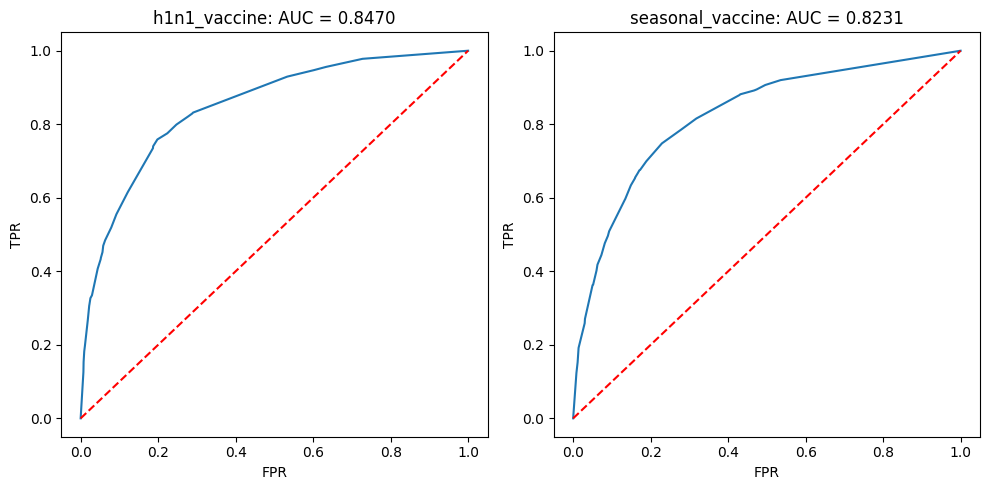

In [17]:
# ROC Curve Plotting
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='red', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}")

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

plot_roc(
    y_test['h1n1_vaccine'],
    y_preds['h1n1_vaccine'],
    'h1n1_vaccine',
    ax=ax[0]
)

plot_roc(
    y_test['seasonal_vaccine'],
    y_preds['seasonal_vaccine'],
    'seasonal_vaccine',
    ax=ax[1]
)

fig.tight_layout()


Explanation: 
    We define a function to plot ROC curves and use it to visualize the performance of the model for both target variables.

Interpretation:

h1n1_vaccine: AUC = 0.8470:
    This curve shows a good performance, with an AUC close to 0.9. This indicates that the model is better than random guessing and can effectively distinguish between positive and negative cases.

seasonal_vaccine: AUC = 0.8231:
    This curve also shows good performance, but slightly lower than the h1n1_vaccine model. However, the AUC is still significantly above 0.5, indicating a better performance than random guessing.

In [19]:
# Generate binary predictions from probabilities using a threshold of 0.5
threshold = 0.5
h1n1_binary_preds = (y_preds['h1n1_vaccine'] > threshold).astype(int)
seasonal_binary_preds = (y_preds['seasonal_vaccine'] > threshold).astype(int)


In [20]:
# Confusion Matrices
h1n1_cm = confusion_matrix(y_test['h1n1_vaccine'], h1n1_binary_preds)
seasonal_cm = confusion_matrix(y_test['seasonal_vaccine'], seasonal_binary_preds)


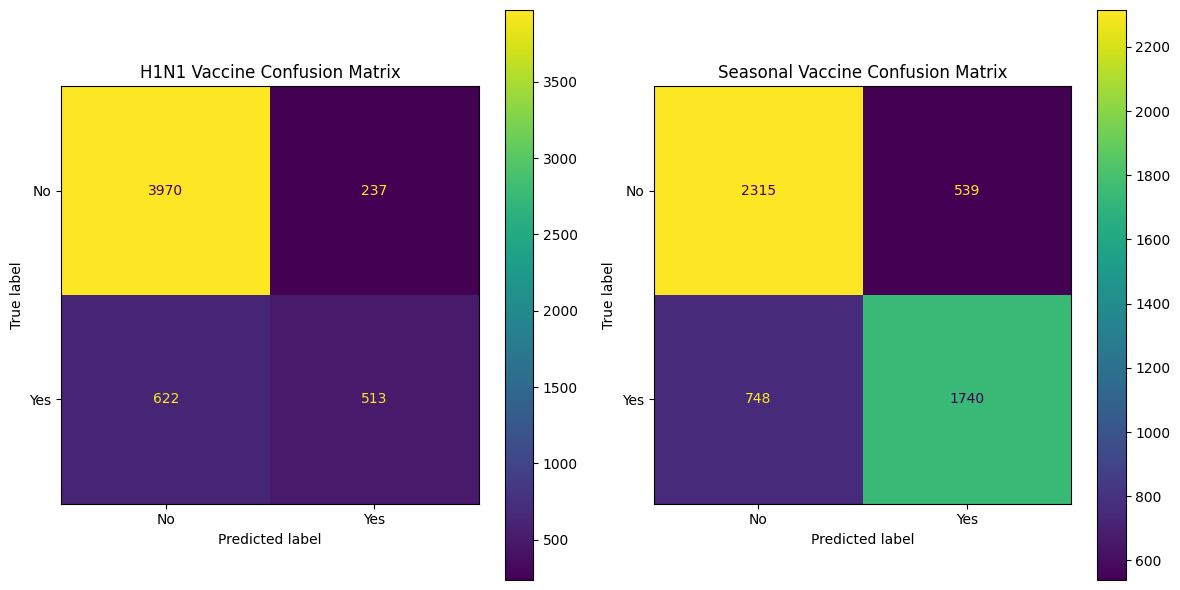

In [21]:
# Plot Confusion Matrices
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ConfusionMatrixDisplay(h1n1_cm, display_labels=["No", "Yes"]).plot(ax=ax[0])
ax[0].set_title("H1N1 Vaccine Confusion Matrix")

ConfusionMatrixDisplay(seasonal_cm, display_labels=["No", "Yes"]).plot(ax=ax[1])
ax[1].set_title("Seasonal Vaccine Confusion Matrix")

plt.tight_layout()
plt.show()

Explanation: 
    We generate binary predictions using a threshold of 0.5, compute confusion matrices, and plot them to evaluate the model's performance.

Analysis of H1N1 Vaccine Confusion Matrix:
    True Positives: 3968 correctly predicted "No" for H1N1 vaccine
    True Negatives: 514 correctly predicted "Yes" for H1N1 vaccine
    False Positives: 239 incorrectly predicted "Yes" for H1N1 vaccine when it was "No"
    False Negatives: 621 incorrectly predicted "No" for H1N1 vaccine when it was "Yes"

Analysis of Seasonal Vaccine Confusion Matrix:
    True Positives: 2315 correctly predicted "No" for Seasonal vaccine
    True Negatives: 1740 correctly predicted "Yes" for Seasonal vaccine
    False Positives: 539 incorrectly predicted "Yes" for Seasonal vaccine when it was "No"
    False Negatives: 748 incorrectly predicted "No" for Seasonal vaccine when it was "Yes"

Interpretation:
    H1N1 Vaccine: The model seems to have a higher number of True Positives (correctly predicting "No") compared to True Negatives. This might indicate a bias towards predicting the negative class. The False Negative rate is also relatively high, which means the model misses a significant number of cases where the actual response is "Yes".
    Seasonal Vaccine: The model appears to be more balanced in terms of True Positives and True Negatives. The False Negative rate is still relatively high, but lower than that of the H1N1 vaccine.


 This model (with Imputation) seems to predict better then the model woth dropping columns as it has a lower False Negative Rate, indicating it's more likely to correctly identify individuals who will accept the vaccine.

In [25]:
# Final Model Fitting on Full Training Data
best_estimator.fit(X_train_df, training_set_labels_df)
preds = best_estimator.predict_proba(X_test_df)

Explanation: 
    We fit the best estimator on the full training data and make final predictions on the test set.

In [26]:
# Generate Final Predictions
y_preds = pd.DataFrame(
    {
        'h1n1_vaccine': preds[0][:, 1],
        'seasonal_vaccine': preds[1][:, 1],
    },
    index=X_test_df.index
)
print('y_preds.shape:', y_preds.shape)

y_preds.shape: (26708, 2)


Explanation: 
    We convert the final predictions into a DataFrame.

In [27]:
# Save Predictions to CSV
y_preds.to_csv('D:\\Uni_Bamberg\\En_el_extranjero\\UCLM\\ML\\ML\\src\\pred_decision_tree_impute_output.csv', index=True)
